## Network Analysis
We defined correlation between businesses based on user-rated 'stars'. The star ranking takes values ranging between 1 - 5. When the star-ranking is positively correlated between two businesses, they are connected with a red edge in the business network. When the star-ranking is negatively correlated between two businesses, they are connected with a blue edge. We used Spearman's ranked correlation analysis. We included the following businesses:
- Restaurants in Phoenix
- Restaurants in Las Vegas

In [68]:
from load_yelp_data import load_yelp_dataframe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
%matplotlib inline
import networkx as nx
import random
import scipy.stats

In [2]:
#Load data
businesses = load_yelp_dataframe('businesses').drop('Unnamed: 0', 1)
reviews = load_yelp_dataframe('reviews').drop('Unnamed: 0', 1)
users = load_yelp_dataframe('users').drop('Unnamed: 0', 1)

In [29]:
businesses.head()

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type,location
0,"{'Accepts Credit Cards': True, 'Noise Level': ...",0,"['Fast Food', 'Restaurants']",Dravosburg,"4734 Lebanon Church Rd\nDravosburg, PA 15034","{'Monday': {'close': '21:00', 'open': '11:00'}...",40.354327,-79.900706,Mr Hoagie,[],True,7,3.5,PA,business,Pittsburgh
1,"{'Accepts Credit Cards': True, 'Price Range': ...",1,['Nightlife'],Dravosburg,"202 McClure St\nDravosburg, PA 15034",{},40.350553,-79.886814,Clancy's Pub,[],True,5,3.0,PA,business,Pittsburgh
2,{'Good for Kids': True},2,"['Active Life', 'Mini Golf', 'Golf']",Bethel Park,"1530 Hamilton Rd\nBethel Park, PA 15234",{},40.354116,-80.014660,Cool Springs Golf Center,[],False,5,2.5,PA,business,Pittsburgh
3,"{'Accepts Credit Cards': True, 'Noise Level': ...",3,"['Bars', 'American (New)', 'Nightlife', 'Loung...",Braddock,"414 Hawkins Ave\nBraddock, PA 15104","{'Tuesday': {'close': '19:00', 'open': '10:00'...",40.408830,-79.866211,Emil's Lounge,[],True,26,4.5,PA,business,Pittsburgh
4,"{'Accepts Credit Cards': True, 'Takes Reservat...",4,"['Active Life', 'Golf']",Braddock,"1000 Clubhouse Dr\nBraddock, PA 15104","{'Friday': {'close': '20:00', 'open': '11:00'}...",40.403405,-79.855782,Grand View Golf Club,[],True,3,5.0,PA,business,Pittsburgh


In [3]:
#Classify the datapoints into the cities based on the latitude and the longitude
cities = np.array([['Edinburgh', 55.9533, -3.1883, 0, 0],
         ['Karlsruhe', 49.0069, 8.4037, 0, 0],
         ['Montreal', 45.5017, -73.5673, 0, 0],
         ['Waterloo', 43.4643, -80.5204, 0, 0],
         ['Pittsburgh', 40.4406, -79.9959, 0, 0],
         ['Charlotte', 35.2271, -80.8431, 0, 0],
         ['Urbana-Champaign', 40.1106, -88.2073, 0, -150000],
         ['Phoenix', 33.4484, -112.0740, 0, 0],
         ['Las Vegas', 36.1699, -115.1398, 0, 0],
         ['Madison', 43.0731, -89.4012, 0, 0]])
lat = np.array(cities[:,1], np.float32)
lon = np.array(cities[:,2], np.float32)
x_offsets = np.array(cities[:,3], np.float32)
y_offsets = np.array(cities[:,4], np.float32)

def classify_datapoint_by_latitude_and_longitude(datapoint):
#     print datapoint
    latitude = datapoint['latitude']
    longitude = datapoint['longitude']
    distances = (latitude - lat)**2 + (longitude - lon)**2
    min_dist = np.argmin(distances)
    return cities[min_dist, 0]

businesses['location'] = businesses.apply(classify_datapoint_by_latitude_and_longitude, axis=1)

In [4]:
##Due to the memory error, first select cities and restaurants
#Choose Las Vegas and Phoenix only
businesses_2cities = businesses[ (businesses['location'] == 'Phoenix') | (businesses['location'] == 'Las Vegas') ]

#Select restaurants
is_restaurants = []
for i in range(0, businesses_2cities.shape[0]):
    if "Restaurants" in businesses_2cities.iloc[i, 2]:
        is_restaurants.append(True)
    else:
        is_restaurants.append(False)

restaurants = businesses_2cities[is_restaurants]

In [5]:
##Clean and merge businesses data with reviews data
#Rename duplicated column names between businesses and reviews datasets
restaurants = restaurants.rename(columns = {'stars': 'stars_business'})

#Merge with the reviews dataset
restaurants_reviews = reviews.merge(restaurants, how='inner', on='business_id') 

#When users reviewed a business more than once, take the most updated review result
restaurants_reviews = restaurants_reviews.sort_values(by=['year', 'month', 'day'], ascending=True, axis=0)
restaurants_reviews_nodup = restaurants_reviews.drop_duplicates(subset=('user_id', 'business_id'), keep='last')

## Las Vegas
We constructed a network of top 100 reviewed restaurants. X axis indicates longitude, and Y axis is latitude.

In [25]:
##Create Las Vegas data##
LVrestaurants = restaurants_reviews_nodup[ restaurants_reviews_nodup['location'] == 'Las Vegas' ]

#Slect top 100 frequently rated restaurants
LV100 = LVrestaurants['business_id'].value_counts()[:100]
LV100id = LV100.index
mask = LVrestaurants['business_id'].isin(LV100id)
LVrestaurants100 = LVrestaurants[mask]

LVrestaurants100_r = LVrestaurants100[['user_id', 'business_id', 'stars']]
LVrestaurants100_t = LVrestaurants100_r.pivot(index='user_id', columns='business_id', values='stars')

#Create correlation matrix of star rating
LVcorr_matrix = LVrestaurants100_t.corr(method='spearman')
LVcorr_matrix_values = LVcorr_matrix.reset_index().values

In [43]:
#Create position for the network
posx = []
for i in range(0, LVrestaurants100.shape[0]):
    posx.append((LVrestaurants100.iloc[i, 1], [LVrestaurants100.iloc[i, 12], LVrestaurants100.iloc[i, 11]]))#business id, longitude, latitude

position_dic = dict(posx)

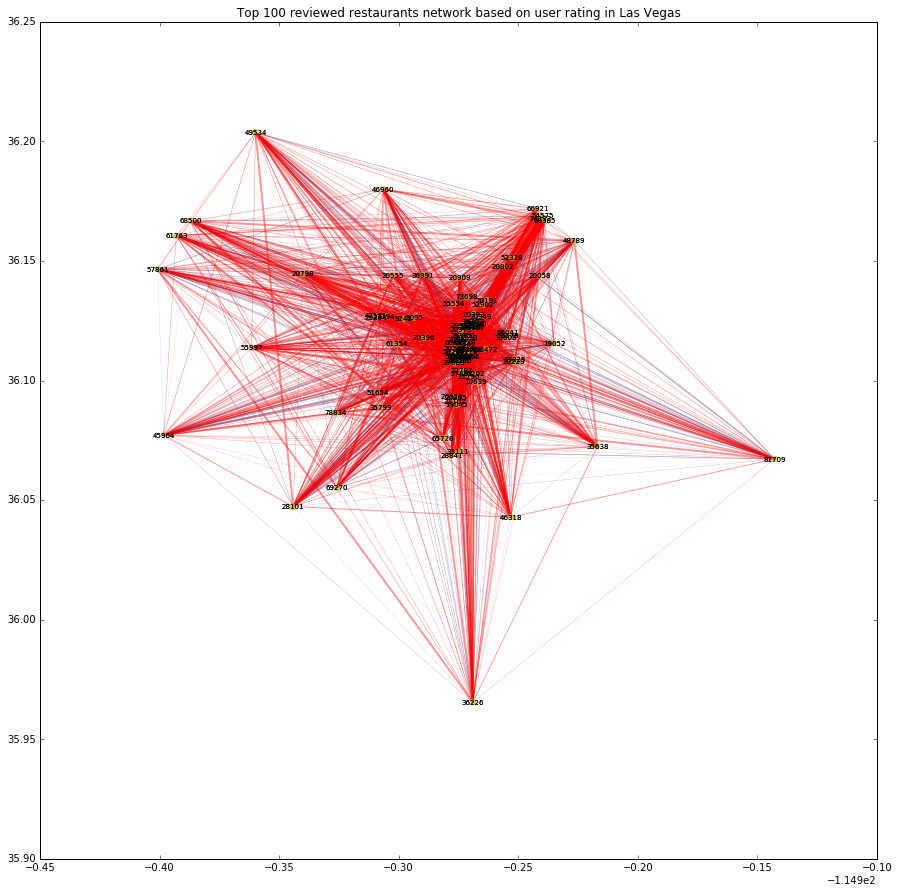

In [53]:
##Construct Las Vegas network using top 100 reviewed restaurants
#x axis longitude, y axis latitude
node0=[]
node1=[]
weight0=[]
weight1=[]
columns=LVcorr_matrix.columns.values
for i, line in enumerate(LVcorr_matrix_values):
    tokens=LVcorr_matrix_values[i]
    row=tokens[0]
    for column, cell in zip(columns[i:],tokens[i+1:]):
        if (cell != "") and (float(cell) < 0):
            node0.append(( int(row), int(column) ))
            weight0.append(float(cell))
        elif (cell != "") and (float(cell) > 0):
            node1.append(( int(row), int(column) ))
            weight1.append(float(cell))

G0=nx.Graph()
G0.add_nodes_from(columns)
G0.add_edges_from(node0)
G1=nx.Graph()
G1.add_nodes_from(columns)
G1.add_edges_from(node1)

weight0x=[i*(-2) for i in weight0]
weight1x=[i*2 for i in weight1]

plt.figure(figsize=(15, 15))
plt.title('Top 100 reviewed restaurants network based on user rating in Las Vegas')
nx.draw_networkx(G0, position_dic, width=weight0x, edge_color='midnightblue', node_color='y', node_size=40, linewidths=0, alpha=0.4, font_size=7)
nx.draw_networkx(G1, position_dic, width=weight1x, edge_color='r',            node_color='y', node_size=40, linewidths=0, alpha=0.4, font_size=7)
plt.show()

Number of nodes 100
Number of total edges 4985
Median degree: 100.0


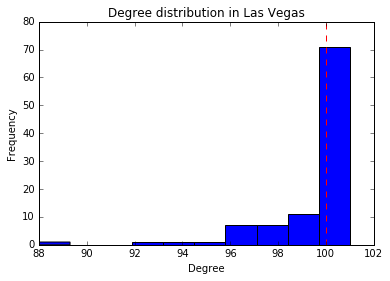

In [63]:
##Network characteristics
# Negative and positive network combined
G01=nx.Graph()
G01.add_nodes_from(columns)
node=[]
node=list(set(node0 + node1))
G01.add_edges_from(node)

#Number of nodes
print 'Number of nodes:', len(G01.nodes())

#Number of edges
print 'Number of total edges:', len(G01.edges()) 

#Median degree
median_degree_LV = np.median(G01.degree().values())
print 'Median degree:', median_degree_LV

#Degree distribution
plt.title('Degree distribution in Las Vegas')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.hist(G01.degree().values())
plt.axvline(median_degree_LV, color='r', linestyle='dashed', linewidth=1)
plt.show()

## Phoenix

In [51]:
##Create Phoenix data##
PHrestaurants = restaurants_reviews_nodup[ restaurants_reviews_nodup['location'] == 'Phoenix' ]

#Slect top 100 frequently rated restaurants
PH100 = PHrestaurants['business_id'].value_counts()[:100]
PH100id = PH100.index
mask = PHrestaurants['business_id'].isin(PH100id)
PHrestaurants100 = PHrestaurants[mask]

PHrestaurants100_r = PHrestaurants100[['user_id', 'business_id', 'stars']]
PHrestaurants100_t = PHrestaurants100_r.pivot(index='user_id', columns='business_id', values='stars')

#Create correlation matrix of star rating
PHcorr_matrix = PHrestaurants100_t.corr(method='spearman')
PHcorr_matrix_values = PHcorr_matrix.reset_index().values

In [52]:
#Create position for the network
posPH = []
for i in range(0, PHrestaurants100.shape[0]):
    posPH.append((PHrestaurants100.iloc[i, 1], [PHrestaurants100.iloc[i, 12], PHrestaurants100.iloc[i, 11]]))#business id, longitude, latitude

positionPH_dic = dict(posPH)

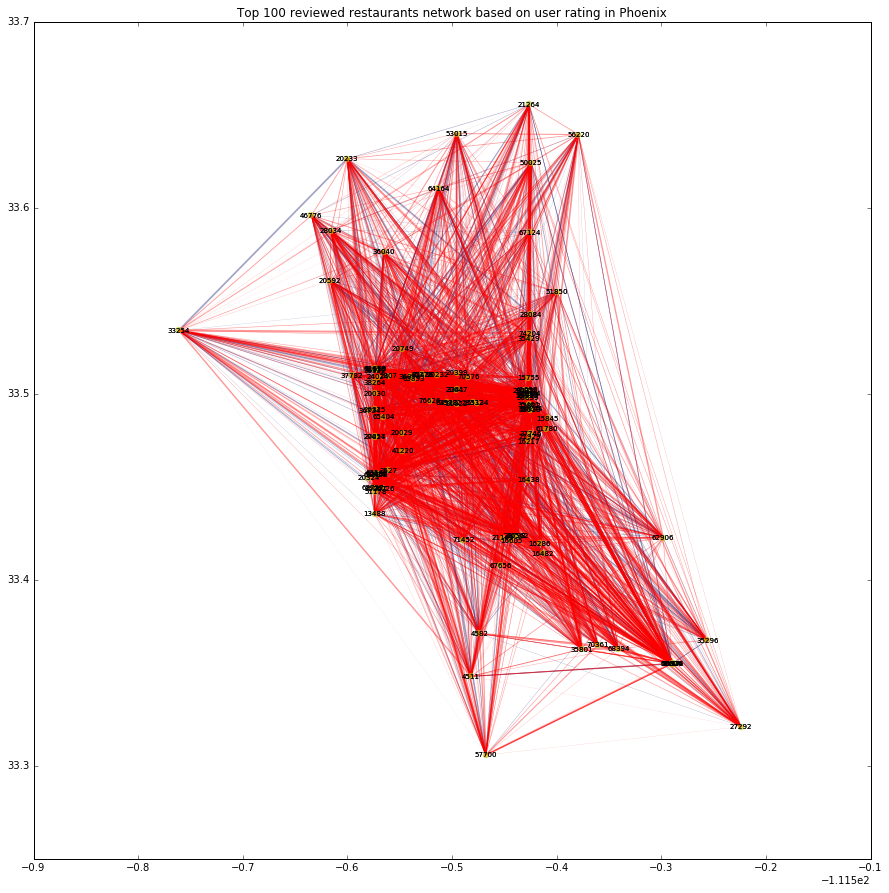

In [54]:
##Construct Phoenix network using top 100 reviewed restaurants
#x axis longitude, y axis latitude
nodePH0=[]
nodePH1=[]
weightPH0=[]
weightPH1=[]
columnsPH=PHcorr_matrix.columns.values
for i, line in enumerate(PHcorr_matrix_values):
    tokens=PHcorr_matrix_values[i]
    row=tokens[0]
    for column, cell in zip(columnsPH[i:],tokens[i+1:]):
        if (cell != "") and (float(cell) < 0):
            nodePH0.append(( int(row), int(column) ))
            weightPH0.append(float(cell))
        elif (cell != "") and (float(cell) > 0):
            nodePH1.append(( int(row), int(column) ))
            weightPH1.append(float(cell))

H0=nx.Graph()
H0.add_nodes_from(columnsPH)
H0.add_edges_from(nodePH0)
H1=nx.Graph()
H1.add_nodes_from(columnsPH)
H1.add_edges_from(nodePH1)

weightPH0x=[i*(-2) for i in weightPH0]
weightPH1x=[i*2 for i in weightPH1]

plt.figure(figsize=(15, 15))
plt.title('Top 100 reviewed restaurants network based on user rating in Phoenix')
nx.draw_networkx(H0, positionPH_dic, width=weightPH0x, edge_color='midnightblue', node_color='y', node_size=40, linewidths=0, alpha=0.4, font_size=7)
nx.draw_networkx(H1, positionPH_dic, width=weightPH1x, edge_color='r',            node_color='y', node_size=40, linewidths=0, alpha=0.4, font_size=7)
plt.show()

Number of nodes: 100
Number of total edges: 4951
Median degree: 100.0


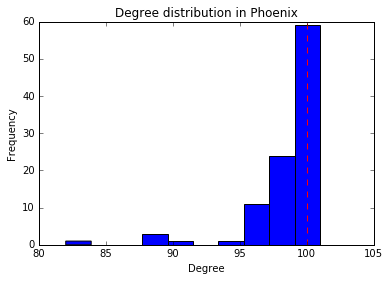

In [64]:
##Network characteristics
# Negative and positive network combined
H01=nx.Graph()
H01.add_nodes_from(columnsPH)
nodePH=[]
nodePH=list(set(nodePH0 + nodePH1))
H01.add_edges_from(nodePH)

#Number of nodes
print 'Number of nodes:', len(H01.nodes())

#Number of edges
print 'Number of total edges:', len(H01.edges()) 

#Median degree
median_degree_PH = np.median(H01.degree().values())
print 'Median degree:', median_degree_PH

#Degree distribution
plt.title('Degree distribution in Phoenix')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.hist(H01.degree().values())
plt.axvline(median_degree_PH, color='r', linestyle='dashed', linewidth=1)
plt.show()

Next step:
- how to filter and select reliable edge (correlation)
- Focus on some nodes?

This preliminary analysis only included 100 businesses (to clearly see the network structure) located in Phoenix. The node in the network figure indicates a business ID, and an edge represents a connection between businesses. The correlation coefficients were calcuated using Spearman's ranked correlation analysis. The red color indicates positive correlation, and the blue color is negative correlation between businesses. The above figure shows that this is an sparse network, and most of the businesses were not rated by users.

In the next step, we will further focus on a specific type of businesses (e.g., restaurant), and refine the selection criteria for cities.